Original Data Head:
    Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  Stock

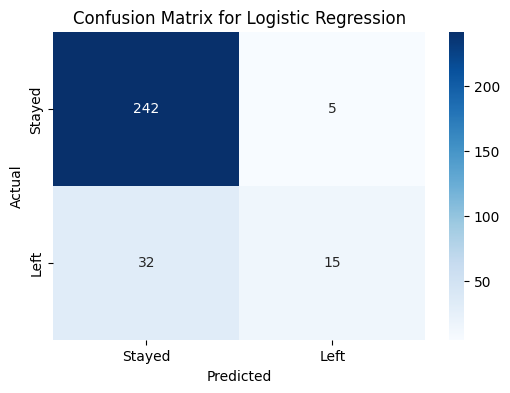


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       247
           1       0.75      0.32      0.45        47

    accuracy                           0.87       294
   macro avg       0.82      0.65      0.69       294
weighted avg       0.86      0.87      0.85       294


--- Training Decision Tree Model ---

--- Decision Tree Evaluation Metrics ---
Accuracy: 0.8095
Precision: 0.3902
Recall: 0.3404
F1-Score: 0.3636
AUC-ROC: 0.6439

Confusion Matrix:
[[222  25]
 [ 31  16]]


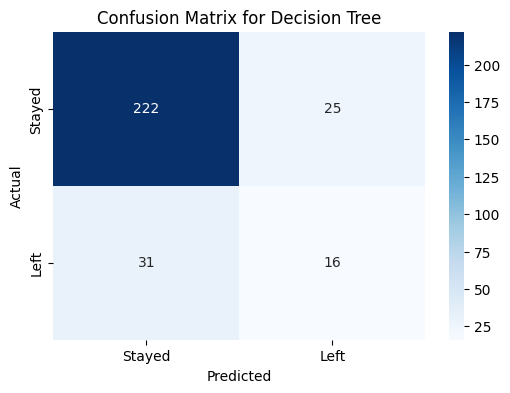


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       247
           1       0.39      0.34      0.36        47

    accuracy                           0.81       294
   macro avg       0.63      0.62      0.63       294
weighted avg       0.80      0.81      0.80       294


--- Training Random Forest Model ---

--- Random Forest Evaluation Metrics ---
Accuracy: 0.8367
Precision: 0.4444
Recall: 0.0851
F1-Score: 0.1429
AUC-ROC: 0.7784

Confusion Matrix:
[[242   5]
 [ 43   4]]


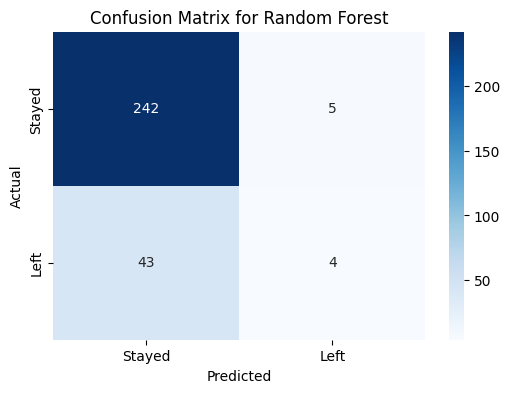


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       247
           1       0.44      0.09      0.14        47

    accuracy                           0.84       294
   macro avg       0.65      0.53      0.53       294
weighted avg       0.78      0.84      0.79       294

Model saved to c:/users/91904/trained_model.pkl
Model loaded from c:/users/91904/trained_model.pkl

--- Making Predictions on Sample New Data ---
      Age                    JobRole  MonthlyIncome  \
1383   36      Laboratory Technician           2810   
557    35  Healthcare Representative           5093   
1147   49      Laboratory Technician           3211   
1145   36     Manufacturing Director           4663   
1366   39            Sales Executive           5736   
...   ...                        ...            ...   
347    47       Sales Representative           2976   
1447   36            Sales Executive           5406   
1232   3

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def load_data():
    """Loads the employee attrition dataset."""
    df = pd.read_csv(r'C:\Users\91904\Downloads\Employee-Attrition - Employee-Attrition.csv')
    return df

def clean_data(df):
    
    dfnew = df.copy()
    columns_to_drop = ['EmployeeCount', 'StandardHours', 'Over18', 'EmployeeNumber']
    
    dfnew = dfnew.drop(columns=columns_to_drop, errors='ignore')
    return dfnew

def preprocess_data(df, target_column='Attrition', test_size=0.2, random_state=42):
   
    df_processed = df

    #print(df_processed.head()) 
    le = LabelEncoder()
    df_processed[target_column] = le.fit_transform(df_processed[target_column]) 
   
    X = df_processed.drop(columns=[target_column])
    y = df_processed[target_column]
   

    # Identify categorical and numerical features
    numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
    # Exclude 'Attrition' if it somehow ended up here (though it shouldn't after drop)
    numerical_features = [col for col in numerical_features if col != target_column]

    categorical_features = X.select_dtypes(include=['object']).columns

    # Create preprocessing pipelines for numerical and categorical features
    numerical_transformer = StandardScaler() # Scale numerical features
    categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-hot encode categorical features

    # Create a preprocessor using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='passthrough' # Keep other columns (if any, though none expected here)
    )

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    return X_train, X_test, y_train, y_test, preprocessor, numerical_features, categorical_features
def train_model(X_train, y_train, preprocessor, model_type='RandomForest'):
    """
    Trains a machine learning model using a pipeline that includes preprocessing.
    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
        preprocessor (ColumnTransformer): The preprocessor object from data_preprocessing.py.
        model_type (str): Type of model to train ('LogisticRegression', 'DecisionTree', 'RandomForest').
    Returns:
        sklearn.pipeline.Pipeline: Trained pipeline (preprocessor + model).
    """
    if model_type == 'LogisticRegression':
        model = LogisticRegression(random_state=42, solver='liblinear', C=0.1) # Added C for regularization
    elif model_type == 'DecisionTree':
        model = DecisionTreeClassifier(random_state=42, max_depth=8, min_samples_leaf=5) # Added params
    elif model_type == 'RandomForest':
        model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, min_samples_leaf=5) # Added params
    else:
        raise ValueError("Invalid model_type. Choose from 'LogisticRegression', 'DecisionTree', 'RandomForest'.")

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    pipeline.fit(X_train, y_train)
    return pipeline    
def evaluate_model(pipeline, X_test, y_test, model_name="Model"):
    """
    Evaluates the trained model and prints various metrics.
    Args:
        pipeline (sklearn.pipeline.Pipeline): The trained pipeline.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target.
        model_name (str): Name of the model for display.
    Returns:
        dict: A dictionary of evaluation metrics.
    """
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] # Probability of attrition

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_prob)
    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc_roc
    }

    print(f"\n--- {model_name} Evaluation Metrics ---")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stayed', 'Left'], yticklabels=['Stayed', 'Left'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return metrics
def save_model(model, filepath='c:/users/91904/trained_model.pkl'):
    """Saves the trained model to a file."""
    joblib.dump(model, filepath)
    print(f"Model saved to {filepath}")

def load_model(filepath='c:/users/91904/trained_model.pkl'):
    """Loads a trained model from a file."""
    model = joblib.load(filepath)
    print(f"Model loaded from {filepath}")
    return model  
def predict_attrition(model, new_data_df):
    
    probabilities = model.predict_proba(new_data_df)[:, 1]
    predictions = model.predict(new_data_df)

    results_df = new_data_df.copy()
    results_df['Predicted_Attrition_Probability'] = probabilities
    results_df['Predicted_Attrition'] = predictions # 0 for Stayed, 1 for Left
    

    return results_df    
def get_at_risk_employees(prediction_df, threshold=0.5):
  
    at_risk_df = prediction_df[prediction_df['Predicted_Attrition_Probability'] >= threshold].sort_values(
        by='Predicted_Attrition_Probability', ascending=False
    )
    return at_risk_df    
if __name__ == '__main__':
    # Example Usage:
    df = load_data()
    print("Original Data Head:\n", df.head())
    print("\nOriginal Data Info:\n")
    df.info()

    df_cleaned = clean_data(df.copy())
    print("\nCleaned Data Head:\n", df_cleaned.head())
    print("\nCleaned Data Info (after dropping constant/ID columns):\n")
    df_cleaned.info()

    X_train, X_test, y_train, y_test, preprocessor, num_feats, cat_feats = preprocess_data(df_cleaned.copy())

    print(f"\nShape of X_train: {X_train.shape}")
    print(f"Shape of X_test: {X_test.shape}")
    print(f"Numerical Features: {num_feats}")
    print(f"Categorical Features: {cat_feats}")
   
    print("\n--- Training Logistic Regression Model ---")
    lr_pipeline = train_model(X_train, y_train, preprocessor, model_type='LogisticRegression')
    lr_metrics = evaluate_model(lr_pipeline, X_test, y_test, model_name='Logistic Regression')

    print("\n--- Training Decision Tree Model ---")
    dt_pipeline = train_model(X_train, y_train, preprocessor, model_type='DecisionTree')
    dt_metrics = evaluate_model(dt_pipeline, X_test, y_test, model_name='Decision Tree')

    print("\n--- Training Random Forest Model ---")
    rf_pipeline = train_model(X_train, y_train, preprocessor, model_type='RandomForest')
    rf_metrics = evaluate_model(rf_pipeline, X_test, y_test, model_name='Random Forest')

    # Choose the best model (e.g., based on AUC-ROC) and save it
    # For demonstration, let's assume Random Forest is chosen
    save_model(rf_pipeline, 'c:/users/91904/trained_model.pkl')

    # Example of loading the model
    #loaded_model = load_model('c:/users/91904/trained_model.pkl')
    try:
        model = load_model('c:/users/91904/trained_model.pkl')
    except FileNotFoundError:
        print("Model not found. Training a Random Forest model...")
        model = train_model(X_train, y_train, preprocessor, model_type='RandomForest')
        save_model(model, 'c:/users/91904/trained_model.pkl')

    # 2. Simulate new data for prediction (e.g., take a few rows from X_test)
    sample_new_data = X_test.sample(100, random_state=1) # Take 100 random employees from test set

    print("\n--- Making Predictions on Sample New Data ---")
    predictions_df = predict_attrition(model, sample_new_data)
    print(predictions_df[['Age', 'JobRole', 'MonthlyIncome', 'Predicted_Attrition_Probability', 'Predicted_Attrition']])

    print("\n--- Identifying At-Risk Employees (Threshold = 0.5) ---")
    at_risk_employees = get_at_risk_employees(predictions_df, threshold=0.5)
    if not at_risk_employees.empty:
        print(at_risk_employees[['Age', 'JobRole', 'MonthlyIncome', 'Predicted_Attrition_Probability']])
    else:
        print("No employees identified as at-risk in the sample data with the current threshold.")

    print("\n--- Identifying At-Risk Employees (Threshold = 0.2, to show more) ---")
    at_risk_employees_low_thresh = get_at_risk_employees(predictions_df, threshold=0.2)
    if not at_risk_employees_low_thresh.empty:
        print(at_risk_employees_low_thresh[['Age', 'JobRole', 'MonthlyIncome', 'Predicted_Attrition_Probability']])
    else:
        print("No employees identified as at-risk in the sample data with the current threshold.")
   